# Fitting power laws

**by Caden Gobat<sup>1</sup>**

<sup>1</sup> Department of Physics, the George Washington University, 725 21st Street NW, Washington, DC 20052, USA

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

## Broken power law functions

A broken power law is a piecewise function given by a sequence of conjoined power laws ($x^\alpha$) where each section has its own power (index) and is defined by bounding "breaks".

Mathematically, the function looks something like
$f(x) \propto \begin{cases} x^{\alpha_0} & \mathrm{if}\ x \leq b_1 \\
x^{\alpha_1} & \mathrm{if}\ b_1 \leq x \leq b_2 \\
... \\
x^{\alpha_n} & \mathrm{if}\ b_n \leq x \leq b_{n+1} \\
... \end{cases}$, where $b_n$ is the $x$-location of the $n$<sup>th</sup> break point.

Alternatively, a single-break power law can be described by a single algebraic expression using a `smoothness' parameter, $\Delta$, that governs the behavior of the transition between the two slopes:

$f(x) \propto \left(\frac{x}{x_b}\right)^{-\alpha_1}\left\{\frac{1}{2}\left[1+\left(\frac{x}{x_b}\right)^{1/\Delta}\right]\right\}^{(\alpha_1-\alpha_2)\Delta}$, where $x_b$ is the break location and $\alpha_1$ and $\alpha_2$ are the power law indices below and above the break, respectively.

The function below is a Python implementation of a generalizable broken power law and takes as input the independent variable, an arbitrarily-long list of break locations, and indices for each section.

In [2]:
def bkn_pow(xvals,breaks,alphas):
    try:
        if len(breaks) != len(alphas) - 1:
            raise ValueError("Dimensional mismatch. There should be one more alpha than there are breaks.")
    except TypeError:
        raise TypeError("Breaks and alphas should be array-like.")
    if any(breaks < np.min(xvals)) or any(breaks > np.max(xvals)):
        raise ValueError("One or more break points fall outside given x bounds.")
    
    breakpoints = [np.min(xvals)] + breaks + [np.max(xvals)] # create a list of all the bounding x-values
    chunks = [np.array([x for x in xvals if x >= breakpoints[i] and x <= breakpoints[i+1]]) for i in range(len(breakpoints)-1)]
    
    all_y = []
    
    #alpha = pd.cut(pd.Series(xvals),breakpoints,labels=alphas,include_lowest=True).to_numpy()

    for idx,xchunk in enumerate(chunks):
        yvals = xchunk**alphas[idx]
        all_y.append(yvals)
    
    for i in range(1,len(all_y)):
        all_y[i] *= np.abs(all_y[i-1][-1]/all_y[i][0])
    
    return(np.array([y for ychunk in all_y for y in ychunk]))

def bkn_pow_smooth(x, A, x_b, a_1, a_2, delta=1):
    a_1 *= -1
    a_2 *= -1
    return A*(x/x_b)**(-a_1) * (0.5*(1+(x/x_b)**(1/delta)))**((a_1-a_2)*delta)

In [3]:
xbounds = (8,18) # log of x bounds
num_points = 200
x = np.logspace(*xbounds,num_points)
breaks = [7e9,1e11,5e12]
alphas = [2,1/3,-1/2,-1]

y = bkn_pow(x,breaks,alphas)

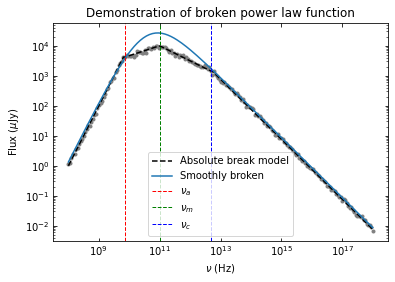

In [4]:
noisy = y * np.random.normal(1,0.1,len(y)) # add Gaussian noise to the data
labels = iter([r'$\nu_a$',r'$\nu_m$',r'$\nu_c$'])
colors = iter('rgb')

plt.loglog(x,noisy/1e16,marker='.',linestyle="",color='grey')
plt.loglog(x,y/1e16,'k--',label="Absolute break model")
plt.loglog(x,bkn_pow_smooth(x,2.2e4,4e10,2,-1,delta=1.1),label="Smoothly broken")

for br in breaks:
    plt.axvline(br,linestyle="--",lw=1,color=next(colors),label=next(labels))

plt.legend()
plt.gca().tick_params(axis='both',which='both',direction='in',top=True,right=True)
plt.xlabel(r"$\nu$ (Hz)")
plt.ylabel(r"Flux ($\mu$Jy)")
plt.title("Demonstration of broken power law function")
plt.show()

## Fitting a broken power law
If we have data that we suspect might be described by a broken PL, the first step is to identify where the function breaks. Then, each piece of the data can be fit with its own index, $\alpha$.

To find the breaks in a dataset that we didn't construct, **we can look for spikes in the second derivative**.

### Central finite difference method for numerical differentiation

Finite differences can be used to get a [numerical approximation of a function's derivative](https://en.wikipedia.org/wiki/Finite_differences#Relation_with_derivatives) where the analytical derivative is unattainable:

\begin{equation}
\frac{\delta_h \lbrack f \rbrack (x)}{h} - f^\prime(x) = O(h^2)
\end{equation}

![finitediff.png](https://images.deepai.org/glossary-terms/3b64fd4ae00945c28f9bb777ed60b0a8/finitediff.png)

A similar thing can be done for second-order derivatives:
\begin{equation}
f^{\prime\prime}(x) \approx \frac{\delta_h^2 \lbrack f\rbrack (x)}{h^2} = \frac{f(x+h)-2f(x)+f(x-h)}{h^2}
\end{equation}

When the function is unknown and the data is in the form of $(x_i,y_i)$ coordinate pairs, we can use the following as an approximation for the second derivative:

\begin{equation}
f^{\prime\prime}(x_i) \approx \frac{y_{i+1} - 2y_i + y_{i-1}}{\left(\frac{x_{i+1}-x_{i-1}}{2}\right)^2}
\end{equation}

In [5]:
def fin_diff_deriv(x,y,order,num_breaks=3):
    from scipy.optimize import curve_fit
    
    logx, logy = np.log10(x), np.log10(y)
    
    first_derivative = []
    second_derivative = []
    
    for idx in range(1,len(logx)-1):
        first_derivative.append((logy[idx+1] - logy[idx-1])/(logx[idx+1]-logx[idx-1]))
        second_derivative.append((logy[idx+1] - 2*logy[idx] + logy[idx-1])/((logx[idx+1]-logx[idx-1])/2)**2)
    
    return [logy,first_derivative,second_derivative][order] # placeholder for debugging: just return numerical derivative rather than anything real, for the moment

### Signal processing and smoothing

Noisy and non-smooth data present a big problem for numerical differentiation techniques. [Chartrand (2011)](http://downloads.hindawi.com/archive/2011/164564.pdf) presents some signal-processing-type solutions. A naïve quick-fix would be to use a rolling mean to smooth the sample. We can also implement a low-pass filter to try to remove some of the noise while preserving the shape of the data.

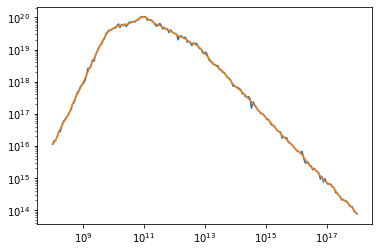

In [6]:
from scipy.signal import savgol_filter, fftconvolve

smoothed = savgol_filter(noisy, 15, 5) # see § 'Savitzky-Golay filtering' below
smoothed = savgol_filter(smoothed,11,3) # second pass

plt.loglog(x,noisy)
plt.loglog(x,smoothed)
plt.show()

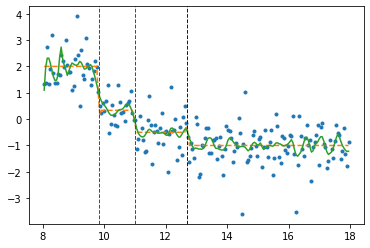

In [7]:
labels = iter([r'$\nu_a$',r'$\nu_m$',r'$\nu_c$'])
colors = iter('rgb')

plt.plot(np.log10(x[1:-1]),fit_bkn_pow(x,noisy,1),".")
plt.plot(np.log10(x[1:-1]),fit_bkn_pow(x,y,1),"--")
plt.plot(np.log10(x[1:-1]),fit_bkn_pow(x,smoothed,1))
#plt.plot(np.log10(x),np.log10(savgol_filter(noisy,25,4,deriv=1)))

for br in breaks:
    plt.axvline(np.log10(br),linestyle="--",lw=1,color=next(colors),label=next(labels))

#### Savitzky-Golay filtering

Savitzky-Golay is a type of low-pass filter, particularly suited for smoothing data with high-frequency noise. The main idea behind this approach is to make for each point a least-square fit with a polynomial of high order over a odd-sized window centered at the point. It has the advantage of preserving the original shape and features of the signal better than other types of filtering approaches, such as moving average techniques.

There is actually already a SciPy function that implements this filter: [`scipy.signal.savgol_filter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html) (as already seen above). I've rewritten it below because it's not that complicated and it's worth seeing how it works.

As input, it takes the noisy data, the filter window size (odd positive integer), the polynomial order to use when filtering, and the order of the derivative to compute (default $0$ will denoise original function only). It outputs smoothed $y$-points.

<u>Example:</u>

```python
t = np.linspace(-4, 4, 500)
y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
ysg = savitzky_golay(y, window_size=31, order=4)
plt.plot(t, y, label='Noisy signal')
plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
plt.plot(t, ysg, 'r', label='Filtered signal')
plt.legend()
plt.show()
```

For more, see [Savitzky & Golay (1964)](https://doi.org/10.1021/ac60214a047) and of course, [Numerical Recipes](http://www.cambridge.org/9780521880688).

In [8]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order should be integers")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be positive and odd")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomial's order")
        
    half_window = (window_size-1) // 2
    
    # precompute coefficients
    b = np.mat([[k**i for i in range(order+1)] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * np.math.factorial(deriv)
    
    # pad the signal at the extremes with values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    
    return np.convolve( m[::-1], y, mode='valid')

In [21]:
def sgolay2d(z, window_size, order, derivative=None):
    
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0

    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')

    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2

    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]

    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])

    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band )
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z

    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band )

    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band )
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band )

    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return fftconvolve(Z, -c, mode='valid')
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return fftconvolve(Z, -r, mode='valid')
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return fftconvolve(Z, -r, mode='valid'), fftconvolve(Z, -c, mode='valid')

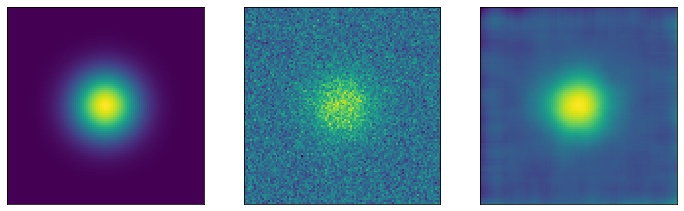

In [48]:
# sample 2D data
x = np.linspace(-3,3,100)
y = np.linspace(-3,3,100)
X, Y = np.meshgrid(x,y)

Z = np.exp( -(X**2+Y**2)) # pure function
Zn = Z + np.random.normal( 0, 0.2, Z.shape ) # added noise
Zf = sgolay2d( Zn, window_size=29, order=4) # re-filtered

fig = plt.figure(figsize=(12,4))
axs = [fig.add_subplot(arr) for arr in [131,132,133]]

for ax,mat in zip(axs,[Z,Zn,Zf]):
    ax.matshow(mat)
    ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,labeltop=False,labelleft=False)